In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance

In [39]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,seaborn

ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Done


## Before you begin

### Set your current URL under `workbench_url`
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/`

### Set a folder to use for all exports under `export_path_root` 
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [3]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


In [4]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/lcms-292214/assets/R8/PR_USVI/TimeSync/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [7]:
Map.proxy_url = workbench_url

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
# for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimsSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))




LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

In [13]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

# Take a look at the resulting cross-walked table
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())
print('Change class counts:',training_data.aggregate_histogram(reference_field_dict['Change']['field']).getInfo())
print('Land cover class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Cover']['field']).getInfo())
print('Land use class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Use']['field']).getInfo())
print('Done')

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Forest', 'DOM_LU_Code': 3, 'DOM_SEC_LC': 'BARREN-TRE', 'DOM_SEC_LC_Code': 5}
Change class counts: {'Debris': 6, 'Fire': 3, 'Growth/Recovery': 2501, 'Harvest': 88, 'Hydrology': 67, 'Mechanical': 197, 'Other': 10, 'Spectral Decline': 30, 'Stable': 17544, 'Structural Decline': 2, 'Wind/Ice': 543}
Land cover class counts: {'BARREN-GRA': 106, 'BARREN-IMP': 2096, 'BARREN-SHR': 108, 'BARREN-TRE': 47, 'GRASS': 2346, 'GRASS-SHRU': 877, 'GRASS-TREE': 1111, 'SHRUBS': 832, 'SHRUBS-TRE': 764, 'TREES': 12100, 'WATER': 604}
Land use class counts: {'Agriculture': 636, 'Developed': 3810, 'Forest': 11824, 'Non-forest Wetland': 999, 'Other': 815, 'Rangeland': 2907}
Done


In [17]:
# Now will download the training table to a local location

local_training_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_training_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_training_data_folder):os.makedirs(local_training_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,...,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,0.0,0.005050,0.099852,0.005145,0.002239,0.0,14.434424,1.446048,3.298604,4.340765,...,26.464866,0.079352,0.005295,0.000475,-0.013667,29.345386,-0.072756,-0.021041,-0.000434,2010.969020
std,0.0,0.070884,0.299810,0.071546,0.047267,0.0,6.677872,1.024257,1.289536,4.450177,...,11.170483,0.040064,0.034007,0.005681,0.029791,10.744572,0.044717,0.042725,0.005656,6.047925
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.483630,1.000000,-0.516985,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,1.000000,3.000000,1.000000,...,17.000000,0.052914,-0.011323,-0.000481,-0.025021,21.000000,-0.096717,-0.039287,-0.001377,2005.906860
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.000000,3.000000,1.000000,...,28.000000,0.069325,0.006184,0.000224,-0.012569,37.000000,-0.065846,-0.021936,-0.000674,2011.208252
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.000000,3.000000,9.000000,...,38.000000,0.095418,0.021533,0.000878,0.000000,38.000000,-0.044558,0.000000,0.000000,2016.167114
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.000000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


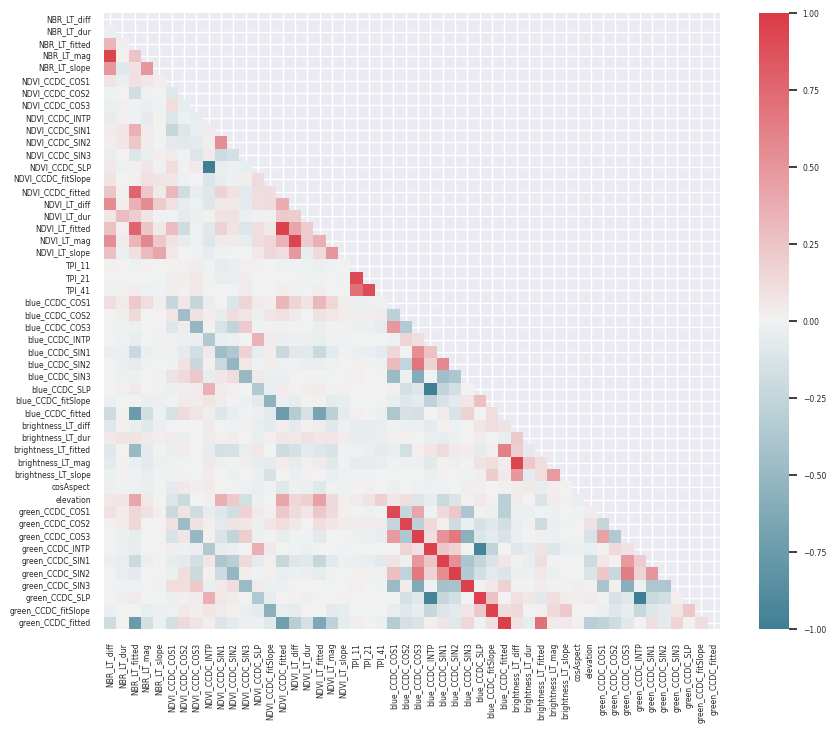

In [46]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))
corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [47]:
# In order to remove correlated variables, we will find pairs with a R2 > 0.95 and take the variable with the lowest average R2

# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    # x = trainingData[indNames]
    indNames = x.columns
    # # reverse order of columns so that Comp features come first for each index so they will be dropped before LT features when correlated
    # x = x[x.columns[::-1]]

    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().abs()
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    # corr_matrix.to_csv(os.path.join(correlatedVarsDir, run_name+'_CorrelationMatrix.csv'), index = False)

    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # This matrix is ordered in order of correlation score. Use this to check. So we drop in order of correlation score.
    # upper['Average_Scores'] = [pd.concat([upper[varName],upper.loc[varName].transpose()]).mean(skipna=True) for varName in upper.columns]

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop


In [73]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_training_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_training_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

Correlated variables: ['red_CCDC_fitted', 'green_CCDC_fitted', 'NDVI_CCDC_fitted', 'blue_CCDC_SIN1', 'green_CCDC_COS3', 'red_CCDC_INTP', 'blue_CCDC_SIN2', 'green_CCDC_INTP', 'green_CCDC_SLP', 'blue_CCDC_INTP', 'swir1_CCDC_SLP', 'swir2_CCDC_SLP', 'green_CCDC_SIN3', 'NDVI_CCDC_SLP', 'green_CCDC_fitSlope', 'nir_CCDC_SLP']


In [132]:
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

nTrees = 50
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    
    # Split them into a test and train set for further model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


All Predictors Change out-of-bag accuracy: 0.9190


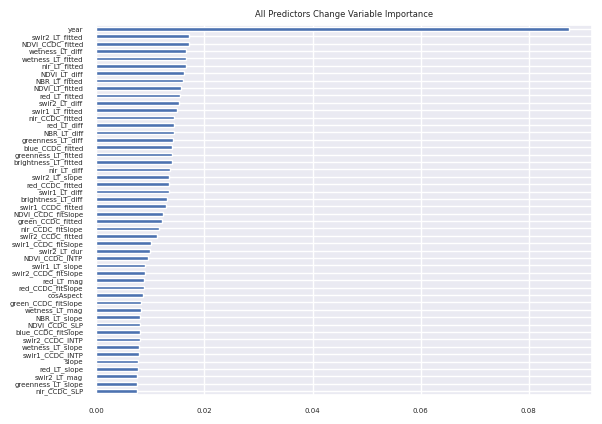

All Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9424    0.9779    0.9598      3530
   Slow Loss     0.8333    0.6250    0.7143         8
   Fast Loss     0.4861    0.2047    0.2881       171
        Gain     0.7751    0.7245    0.7489       490

    accuracy                         0.9162      4199
   macro avg     0.7592    0.6330    0.6778      4199
weighted avg     0.9041    0.9162    0.9074      4199

All Predictors Change Overall Accuracy: 0.9162
All Predictors Change Balanced Accuracy: 0.6330
All Predictors Change Kappa: 0.6689
Non-correlated Predictors Change out-of-bag accuracy: 0.9192


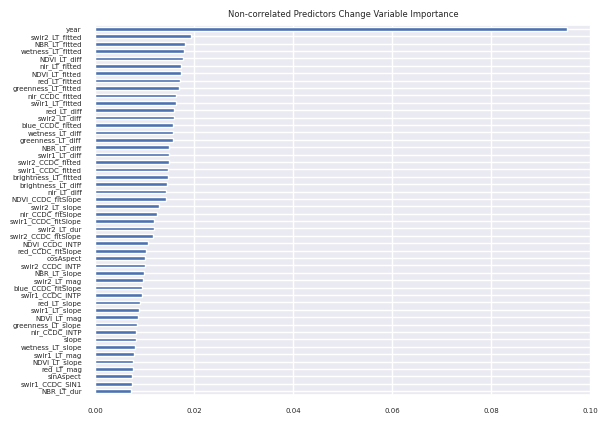

Non-correlated Predictors Change report:
              precision    recall  f1-score   support

      Stable     0.9361    0.9855    0.9601      3506
   Slow Loss     0.6667    0.5714    0.6154         7
   Fast Loss     0.6154    0.2105    0.3137       190
        Gain     0.7918    0.6976    0.7417       496

    accuracy                         0.9157      4199
   macro avg     0.7525    0.6162    0.6577      4199
weighted avg     0.9041    0.9157    0.9045      4199

Non-correlated Predictors Change Overall Accuracy: 0.9157
Non-correlated Predictors Change Balanced Accuracy: 0.6162
Non-correlated Predictors Change Kappa: 0.6669
Top 30 Var Imp Change out-of-bag accuracy: 0.9200


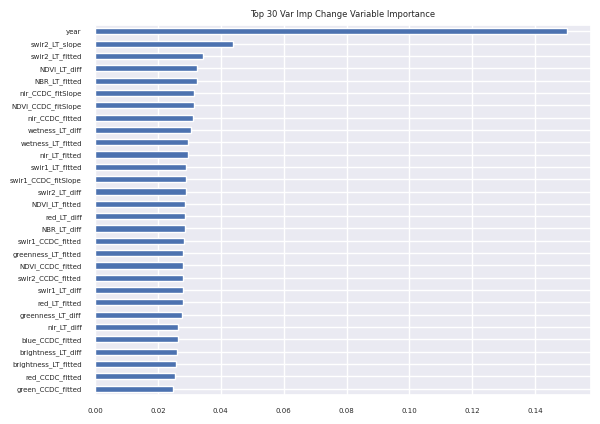

Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9268    0.9858    0.9554      3532
   Slow Loss     0.0000    0.0000    0.0000         5
   Fast Loss     0.7895    0.5114    0.6207       176
        Gain     0.8750    0.5905    0.7052       486

    accuracy                         0.9190      4199
   macro avg     0.6478    0.5219    0.5703      4199
weighted avg     0.9139    0.9190    0.9113      4199

Top 30 Var Imp Change Overall Accuracy: 0.9190
Top 30 Var Imp Change Balanced Accuracy: 0.5219
Top 30 Var Imp Change Kappa: 0.6587


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non Corr Top 30 Var Imp Change out-of-bag accuracy: 0.9265


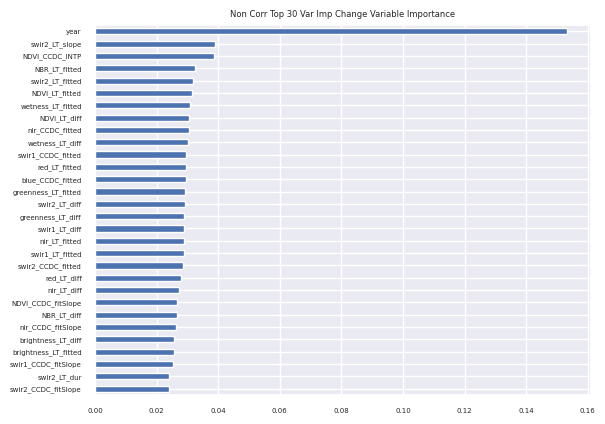

Non Corr Top 30 Var Imp Change report:
              precision    recall  f1-score   support

      Stable     0.9288    0.9889    0.9579      3510
   Slow Loss     1.0000    0.5000    0.6667         4
   Fast Loss     0.7982    0.4888    0.6063       178
        Gain     0.9031    0.6252    0.7389       507

    accuracy                         0.9233      4199
   macro avg     0.9075    0.6507    0.7424      4199
weighted avg     0.9202    0.9233    0.9163      4199

Non Corr Top 30 Var Imp Change Overall Accuracy: 0.9233
Non Corr Top 30 Var Imp Change Balanced Accuracy: 0.6507
Non Corr Top 30 Var Imp Change Kappa: 0.6868
All Predictors Land Cover out-of-bag accuracy: 0.9765


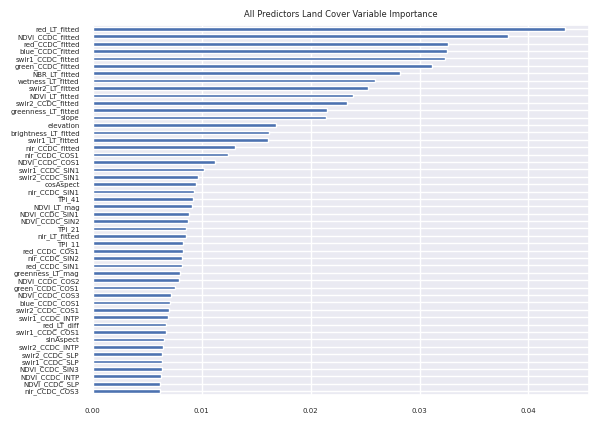

All Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9817    0.9928    0.9872      2376
          Shrubs & Trees Mix     0.9474    0.8727    0.9085       165
 Grass/Forb/Herb & Trees Mix     0.9083    0.8739    0.8908       238
          Barren & Trees Mix     0.8000    0.5714    0.6667         7
                      Shrubs     0.9542    0.9182    0.9359       159
Grass/Forb/Herb & Shrubs Mix     0.9293    0.9048    0.9169       189
         Barren & Shrubs Mix     0.9545    0.9130    0.9333        23
             Grass/Forb/Herb     0.9360    0.9679    0.9517       468
Barren & Grass/Forb/Herb Mix     0.6000    0.4000    0.4800        15
        Barren or Impervious     0.9793    0.9770    0.9781       435
                       Water     1.0000    0.9919    0.9960       124

                    accuracy                         0.9669      4199
                   macro avg     0.9082    0.8531    0

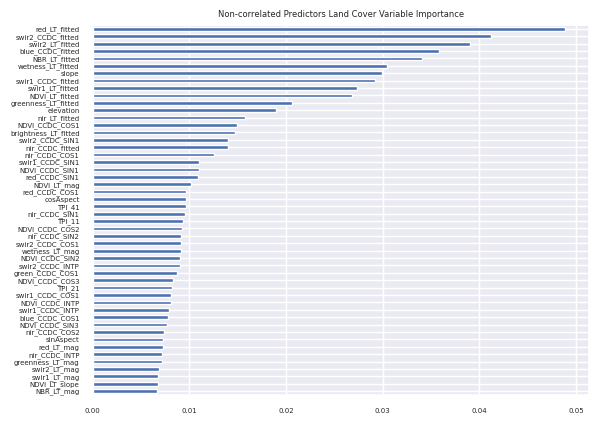

Non-correlated Predictors Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9885    0.9897    0.9891      2436
          Shrubs & Trees Mix     0.8903    0.9200    0.9049       150
 Grass/Forb/Herb & Trees Mix     0.8955    0.9249    0.9099       213
          Barren & Trees Mix     0.5455    0.5000    0.5217        12
                      Shrubs     0.9670    0.9462    0.9565       186
Grass/Forb/Herb & Shrubs Mix     0.9360    0.8703    0.9020       185
         Barren & Shrubs Mix     1.0000    1.0000    1.0000        17
             Grass/Forb/Herb     0.9595    0.9677    0.9636       465
Barren & Grass/Forb/Herb Mix     0.8571    0.9000    0.8780        20
        Barren or Impervious     0.9775    0.9775    0.9775       400
                       Water     1.0000    0.9826    0.9912       115

                    accuracy                         0.9712      4199
                   macro avg     0.9106    

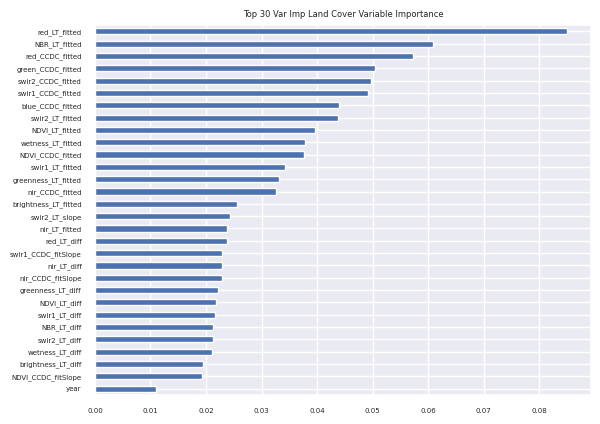

Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9607    0.9938    0.9770      2436
          Shrubs & Trees Mix     0.9600    0.8108    0.8791       148
 Grass/Forb/Herb & Trees Mix     0.9268    0.8120    0.8656       234
          Barren & Trees Mix     0.7500    0.3000    0.4286        10
                      Shrubs     0.9533    0.8462    0.8966       169
Grass/Forb/Herb & Shrubs Mix     0.9198    0.8563    0.8869       174
         Barren & Shrubs Mix     0.9333    0.9333    0.9333        15
             Grass/Forb/Herb     0.9522    0.9481    0.9501       462
Barren & Grass/Forb/Herb Mix     1.0000    0.5263    0.6897        19
        Barren or Impervious     0.9535    0.9903    0.9716       414
                       Water     0.9746    0.9746    0.9746       118

                    accuracy                         0.9557      4199
                   macro avg     0.9349    0.8174    0

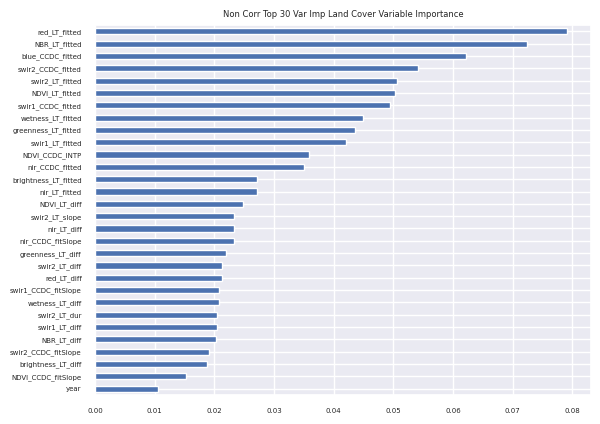

Non Corr Top 30 Var Imp Land Cover report:
                              precision    recall  f1-score   support

                       Trees     0.9596    0.9957    0.9773      2335
          Shrubs & Trees Mix     0.9481    0.7758    0.8533       165
 Grass/Forb/Herb & Trees Mix     0.9154    0.8638    0.8889       213
          Barren & Trees Mix     1.0000    0.2857    0.4444         7
                      Shrubs     0.9586    0.8901    0.9231       182
Grass/Forb/Herb & Shrubs Mix     0.9314    0.8402    0.8835       194
         Barren & Shrubs Mix     1.0000    0.9286    0.9630        28
             Grass/Forb/Herb     0.9468    0.9507    0.9488       487
Barren & Grass/Forb/Herb Mix     0.8696    0.6452    0.7407        31
        Barren or Impervious     0.9648    0.9693    0.9671       424
                       Water     1.0000    0.9774    0.9886       133

                    accuracy                         0.9559      4199
                   macro avg     0.9540    0.

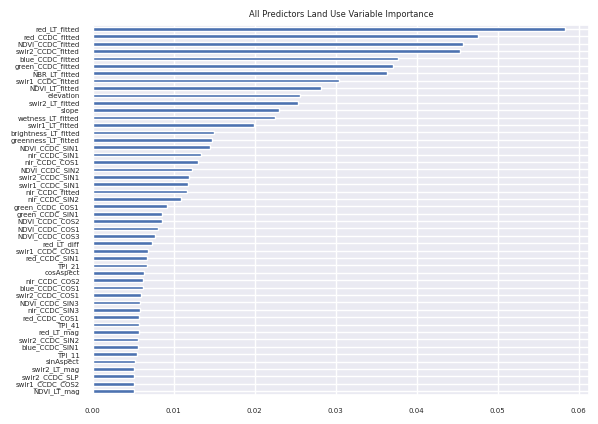

All Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9839    0.9919       124
           Developed     0.9934    0.9934    0.9934       763
              Forest     0.9970    0.9992    0.9981      2356
  Non-Forest Wetland     0.9953    0.9906    0.9929       213
               Other     0.9939    1.0000    0.9969       162
Rangeland or Pasture     0.9931    0.9880    0.9905       581

            accuracy                         0.9957      4199
           macro avg     0.9955    0.9925    0.9940      4199
        weighted avg     0.9957    0.9957    0.9957      4199

All Predictors Land Use Overall Accuracy: 0.9957
All Predictors Land Use Balanced Accuracy: 0.9925
All Predictors Land Use Kappa: 0.9932
Non-correlated Predictors Land Use out-of-bag accuracy: 0.9951


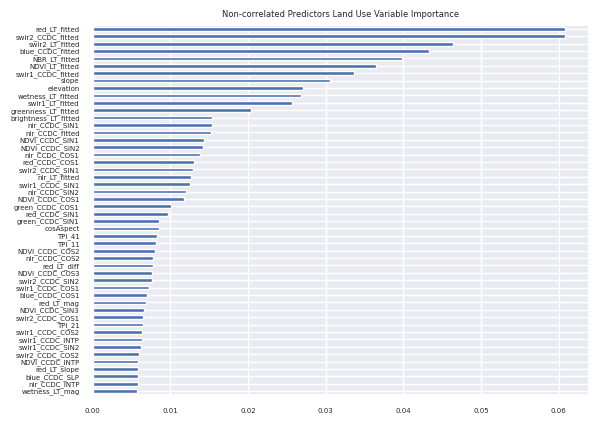

Non-correlated Predictors Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9915    0.9957       118
           Developed     0.9975    0.9975    0.9975       792
              Forest     0.9966    0.9983    0.9975      2352
  Non-Forest Wetland     0.9947    0.9947    0.9947       188
               Other     1.0000    0.9875    0.9937       160
Rangeland or Pasture     0.9915    0.9898    0.9907       589

            accuracy                         0.9962      4199
           macro avg     0.9967    0.9932    0.9950      4199
        weighted avg     0.9962    0.9962    0.9962      4199

Non-correlated Predictors Land Use Overall Accuracy: 0.9962
Non-correlated Predictors Land Use Balanced Accuracy: 0.9932
Non-correlated Predictors Land Use Kappa: 0.9939
Top 30 Var Imp Land Use out-of-bag accuracy: 0.9788


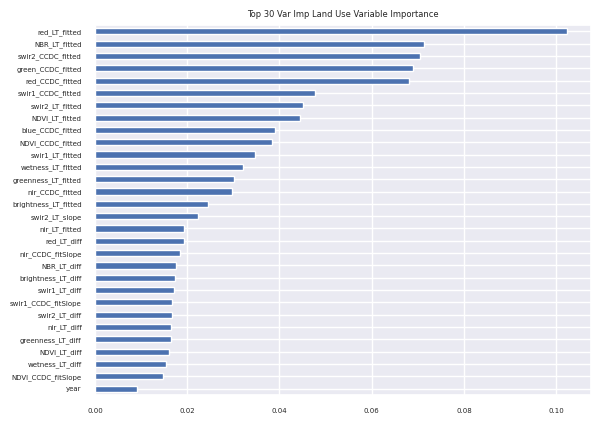

Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     0.9739    0.8750    0.9218       128
           Developed     0.9684    0.9892    0.9787       743
              Forest     0.9746    0.9921    0.9833      2400
  Non-Forest Wetland     0.9947    0.9130    0.9521       207
               Other     0.9669    0.9182    0.9419       159
Rangeland or Pasture     0.9667    0.9306    0.9483       562

            accuracy                         0.9731      4199
           macro avg     0.9742    0.9364    0.9544      4199
        weighted avg     0.9731    0.9731    0.9728      4199

Top 30 Var Imp Land Use Overall Accuracy: 0.9731
Top 30 Var Imp Land Use Balanced Accuracy: 0.9364
Top 30 Var Imp Land Use Kappa: 0.9562
Non Corr Top 30 Var Imp Land Use out-of-bag accuracy: 0.9826


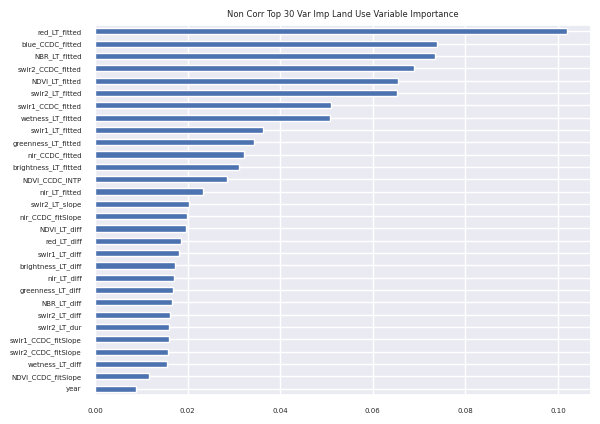

Non Corr Top 30 Var Imp Land Use report:
                      precision    recall  f1-score   support

         Agriculture     1.0000    0.9535    0.9762       129
           Developed     0.9703    0.9934    0.9817       756
              Forest     0.9809    0.9944    0.9876      2329
  Non-Forest Wetland     0.9831    0.9409    0.9615       186
               Other     0.9876    0.9695    0.9785       164
Rangeland or Pasture     0.9817    0.9307    0.9555       635

            accuracy                         0.9800      4199
           macro avg     0.9839    0.9637    0.9735      4199
        weighted avg     0.9801    0.9800    0.9798      4199

Non Corr Top 30 Var Imp Land Use Overall Accuracy: 0.9800
Non Corr Top 30 Var Imp Land Use Balanced Accuracy: 0.9637
Non Corr Top 30 Var Imp Land Use Kappa: 0.9682
Done


In [133]:
# Now evaluate models for each LCMS product and create a summary table
product_names = ['Change','Land_Cover','Land_Use']
acc_table = []
for product_name in product_names:
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
#     print(all_var_imp)
    all_top30_model_info = list(fit_rf(product_name,all_var_imp[:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_var_imp[:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

In [134]:
a = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(a)

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.918965,0.916171,0.633018,0.668928,"[year, swir2_LT_fitted, NDVI_CCDC_fitted, wetn..."
1,Change,Non-correlated Predictors,0.919156,0.915694,0.616247,0.666851,"[year, swir2_LT_fitted, NBR_LT_fitted, wetness..."
2,Change,All Predictors Top 30,0.919966,0.919028,0.521936,0.658651,"[year, swir2_LT_slope, swir2_LT_fitted, NDVI_L..."
3,Change,Non-correlated Predictors Top 30,0.926492,0.923315,0.650725,0.686828,"[year, swir2_LT_slope, NDVI_CCDC_INTP, NBR_LT_..."
4,Land_Cover,All Predictors,0.976466,0.966897,0.853081,0.948586,"[red_LT_fitted, NDVI_CCDC_fitted, red_CCDC_fit..."
5,Land_Cover,Non-correlated Predictors,0.975323,0.971184,0.907180,0.954483,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."
6,Land_Cover,All Predictors Top 30,0.960030,0.955704,0.817428,0.928791,"[red_LT_fitted, NBR_LT_fitted, red_CCDC_fitted..."
7,Land_Cover,Non-correlated Predictors Top 30,0.962174,0.955942,0.829326,0.931898,"[red_LT_fitted, NBR_LT_fitted, blue_CCDC_fitte..."
8,Land_Use,All Predictors,0.994903,0.995713,0.992505,0.993169,"[red_LT_fitted, red_CCDC_fitted, NDVI_CCDC_fit..."
9,Land_Use,Non-correlated Predictors,0.995141,0.996190,0.993216,0.993916,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."


In [110]:
os.listdir(local_training_data_folder)

['no_corr_predictor_field_names.csv',
 'all_predictor_field_names.csv',
 'timeSync_training_table.csv']

Getting model info for All Predictors Land Cover
All Predictors Land Cover OOB Accuracy: 0.9757038730884665


,Trees,Tall Shrubs & Trees Mix (SEAK Only),Shrubs & Trees Mix,Grass/Forb/Herb & Trees Mix,Barren & Trees Mix,Tall Shrubs (SEAK Only),Shrubs,Grass/Forb/Herb & Shrubs Mix,Barren & Shrubs Mix,Grass/Forb/Herb,Barren & Grass/Forb/Herb Mix,Barren or Impervious,Snow or Ice,Water,Producers Accuracy (1 - omission error)
Trees,12100,0,0,0,0,0,0,0,0,0,0,0,0,0,100
Tall Shrubs & Trees Mix (SEAK Only),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Shrubs & Trees Mix,14,0,749,0,0,0,0,0,1,0,0,0,0,0,98
Grass/Forb/Herb & Trees Mix,9,0,0,1101,0,0,0,0,0,1,0,0,0,0,99
Barren & Trees Mix,1,0,0,0,46,0,0,0,0,0,0,0,0,0,97
Tall Shrubs (SEAK Only),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Shrubs,1,0,2,0,0,0,829,0,0,0,0,0,0,0,99
Grass/Forb/Herb & Shrubs Mix,0,0,0,1,0,0,2,873,0,1,0,0,0,0,99
Barren & Shrubs Mix,0,0,0,0,0,0,0,0,108,0,0,0,0,0,100
Grass/Forb/Herb,0,0,0,0,0,0,0,0,0,2346,0,0,0,0,100


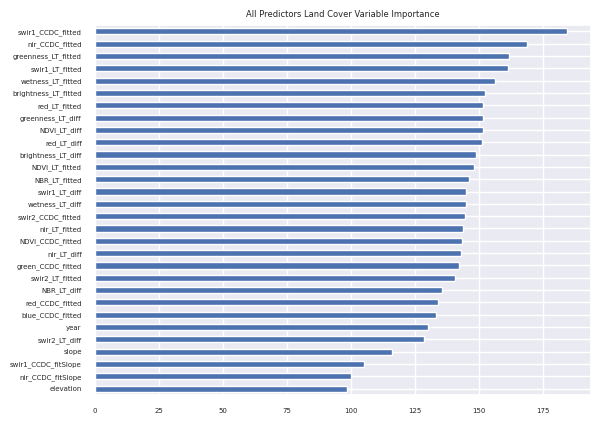

Getting model info for All Predictors Land Use
All Predictors Land Use OOB Accuracy: 0.9942832642561098


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy (1 - omission error)
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11824,0,0,0,100
Non-Forest Wetland,0,0,0,999,0,0,100
Other,0,1,0,1,813,0,99
Rangeland or Pasture,0,0,0,0,0,2907,100
Consumers Accuracy (1 - commission error),100,99,100,99,100,100,99


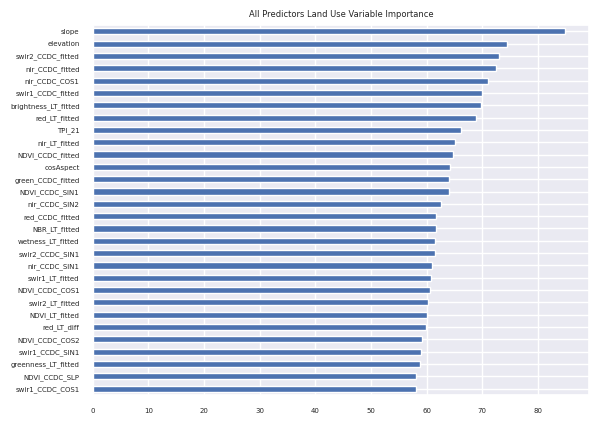

Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.9221094754894955


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17542,0,0,2,99
Slow Loss,1,31,0,0,96
Fast Loss,57,0,852,5,93
Gain,20,0,0,2481,99
Consumers Accuracy (1 - commission error),99,100,100,99,99


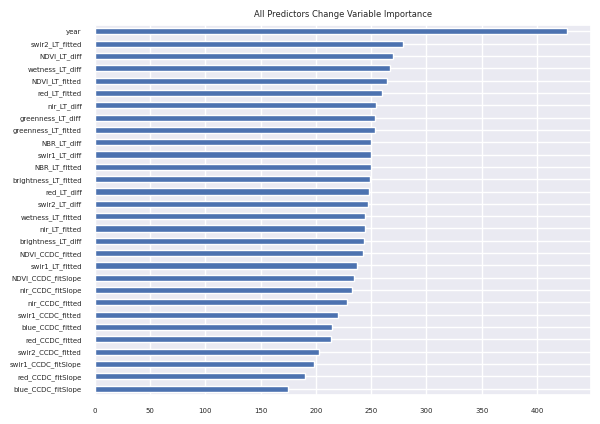

In [67]:

# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model

# Get predictor stack for apply year
# predictor_stack = getPredictorStack(apply_year)

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
#     importance_dict = dict( sorted(importance_dict.items(), key=operator.itemgetter(1),reverse=not descending))
#     fig, ax = plt.subplots()
#     ax.barh(list(importance_dict.keys())[-n_variables:], list(importance_dict.values())[-n_variables:])
#     ax.set_title(title)
#     plt.xticks(rotation=90,size=6)
#     plt.show()
    # return importance_dict

# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(confusionMatrix.accuracy().getInfo()*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in confusionMatrix.consumersAccuracy().getInfo()[0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in confusionMatrix.producersAccuracy().getInfo()[1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = confusionMatrix.getInfo()
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model inf
    importance = getModelInfo(rf, lcms_viz_dict[f'{product_name}_class_names'][:-1],f'All Predictors {product_title}')
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')

for product in ['Land_Cover','Land_Use','Change']:
    fit_rf(product)
# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

In [157]:

# Now, we'll explore the 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import numpy as np
import os

# Set some parameters
nTrees = 50 # Number of trees to use in the Random Forest model. > 50 can result in memory errors and generally doesn't help the model much
seed = 0 # Set a seed to ensure the same model is recreated with each run. Change this if a new one is needed
top_n_variables = 30 # Take this number of variables into the final model
apply_year = 2017 # Year to apply model to

# Get predictor stack for apply year
predictor_stack = getPredictorStack(apply_year)
predictor_field_names = ['NBR_LT_dur', 'NBR_LT_fitted', 'NBR_LT_mag', 'NBR_LT_slope', 'NBR_LT_diff', 'NDVI_LT_dur', 'NDVI_LT_fitted', 'NDVI_LT_mag', 'NDVI_LT_slope', 'NDVI_LT_diff', 'brightness_LT_dur', 'brightness_LT_fitted', 'brightness_LT_mag', 'brightness_LT_slope', 'brightness_LT_diff', 'greenness_LT_dur', 'greenness_LT_fitted', 'greenness_LT_mag', 'greenness_LT_slope', 'greenness_LT_diff', 'nir_LT_dur', 'nir_LT_fitted', 'nir_LT_mag', 'nir_LT_slope', 'nir_LT_diff', 'red_LT_dur', 'red_LT_fitted', 'red_LT_mag', 'red_LT_slope', 'red_LT_diff', 'swir1_LT_dur', 'swir1_LT_fitted', 'swir1_LT_mag', 'swir1_LT_slope', 'swir1_LT_diff', 'swir2_LT_dur', 'swir2_LT_fitted', 'swir2_LT_mag', 'swir2_LT_slope', 'swir2_LT_diff', 'wetness_LT_dur', 'wetness_LT_fitted', 'wetness_LT_mag', 'wetness_LT_slope', 'wetness_LT_diff', 'year', 'blue_CCDC_INTP', 'blue_CCDC_SLP', 'blue_CCDC_COS1', 'blue_CCDC_SIN1', 'blue_CCDC_COS2', 'blue_CCDC_SIN2', 'blue_CCDC_COS3', 'blue_CCDC_SIN3', 'green_CCDC_INTP', 'green_CCDC_SLP', 'green_CCDC_COS1', 'green_CCDC_SIN1', 'green_CCDC_COS2', 'green_CCDC_SIN2', 'green_CCDC_COS3', 'green_CCDC_SIN3', 'red_CCDC_INTP', 'red_CCDC_SLP', 'red_CCDC_COS1', 'red_CCDC_SIN1', 'red_CCDC_COS2', 'red_CCDC_SIN2', 'red_CCDC_COS3', 'red_CCDC_SIN3', 'nir_CCDC_INTP', 'nir_CCDC_SLP', 'nir_CCDC_COS1', 'nir_CCDC_SIN1', 'nir_CCDC_COS2', 'nir_CCDC_SIN2', 'nir_CCDC_COS3', 'nir_CCDC_SIN3', 'swir1_CCDC_INTP', 'swir1_CCDC_SLP', 'swir1_CCDC_COS1', 'swir1_CCDC_SIN1', 'swir1_CCDC_COS2', 'swir1_CCDC_SIN2', 'swir1_CCDC_COS3', 'swir1_CCDC_SIN3', 'swir2_CCDC_INTP', 'swir2_CCDC_SLP', 'swir2_CCDC_COS1', 'swir2_CCDC_SIN1', 'swir2_CCDC_COS2', 'swir2_CCDC_SIN2', 'swir2_CCDC_COS3', 'swir2_CCDC_SIN3', 'NDVI_CCDC_INTP', 'NDVI_CCDC_SLP', 'NDVI_CCDC_COS1', 'NDVI_CCDC_SIN1', 'NDVI_CCDC_COS2', 'NDVI_CCDC_SIN2', 'NDVI_CCDC_COS3', 'NDVI_CCDC_SIN3', 'NDVI_CCDC_fitted', 'blue_CCDC_fitted', 'green_CCDC_fitted', 'nir_CCDC_fitted', 'red_CCDC_fitted', 'swir1_CCDC_fitted', 'swir2_CCDC_fitted', 'NDVI_CCDC_fitSlope', 'blue_CCDC_fitSlope', 'green_CCDC_fitSlope', 'nir_CCDC_fitSlope', 'red_CCDC_fitSlope', 'swir1_CCDC_fitSlope', 'swir2_CCDC_fitSlope', 'sinAspect', 'cosAspect', 'TPI_11', 'TPI_21', 'TPI_41']#predictor_stack.bandNames().getInfo()
# print(predictor_field_names)
# Specify a local location to store LCMS training data \
local_training_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_training_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_training_data_folder):os.makedirs(local_training_data_folder)

# Download the training data from a featureCollection to a local CSV
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)
training_df = pd.read_csv(local_training_csv)

training_df.describe()
# import matplotlib.pyplot as plt

# plt.matshow(training_df[predictor_field_names].corr())
# plt.xticks(predictor_field_names, fontsize=5, rotation=45)
# plt.yticks(predictor_field_names, fontsize=5)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);
# plt.show()


import seaborn as sns


corr = training_df[predictor_field_names].corr()

sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

corr = corr[abs(corr) >= 0.95].stack().reset_index()
corr = corr[corr['level_0'].astype(str)!=corr['level_1'].astype(str)]
print(corr)
# # # filtering out lower/upper triangular duplicates 
# corr['ordered-cols'] = corr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
# corr = corr.drop_duplicates(['ordered-cols'])
# corr.drop(['ordered-cols'], axis=1, inplace=True)
# corr_predictor_field_names = corr['level_1'].tolist()
# predictor_field_names_no_corr = [i for i in predictor_field_names if i not in corr_predictor_field_names] 
# print('Removing the following correlated variables:',corr_predictor_field_names)
# print(f'Reduced n predictors from {len(predictor_field_names)} to {len(predictor_field_names_no_corr)}')

# corr = training_df[predictor_field_names_no_corr].corr()
# sns.set(font_scale=0.3)
# f, ax = plt.subplots(figsize=(10, 8))
# sns.heatmap(corr,
#     cmap=sns.diverging_palette(220, 10, as_cmap=True),
#     vmin=-1.0, vmax=1.0,
#     square=True, ax=ax)

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists
                 level_0              level_1         0
7         NDVI_LT_fitted     NDVI_CCDC_fitted  0.959241
48        blue_CCDC_INTP        blue_CCDC_SLP -0.999989
49        blue_CCDC_INTP      green_CCDC_INTP  0.957528
50        blue_CCDC_INTP       green_CCDC_SLP -0.957166
51         blue_CCDC_SLP       blue_CCDC_INTP -0.999989
53         blue_CCDC_SLP      green_CCDC_INTP -0.957639
54         blue_CCDC_SLP       green_CCDC_SLP  0.957303
57        blue_CCDC_SIN1      green_CCDC_SIN1  0.958458
60        blue_CCDC_SIN2      green_CCDC_SIN2  0.976189
62        blue_CCDC_COS3      green_CCDC_COS3  0.970601
64        blue_CCDC_SIN3      green_CCDC_SIN3  0.966460
65       green_CCDC_INTP       blue_CCDC_INTP  0.957528
66       green_CCDC_INTP        blue_CCDC_SLP -0.957639
68       green_CCDC_INTP       green_CCDC_SLP -0.999983
69        green_CCDC_SLP       blue_CCDC_INTP -0.957166
70        green_CCDC_SLP  

In [64]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10,scoring = 'balanced_accuracy')
scores
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

NameError: name 'rf' is not defined

All Variables Land Use OOB Accuracy: 0.9936636493568366


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11823,0,0,0,100
Non-Forest Wetland,0,0,1,997,1,0,99
Other,0,0,0,1,814,0,99
Rangeland or Pasture,0,0,1,0,0,2906,99
Consumers Accuracy,100,100,99,99,99,100,99


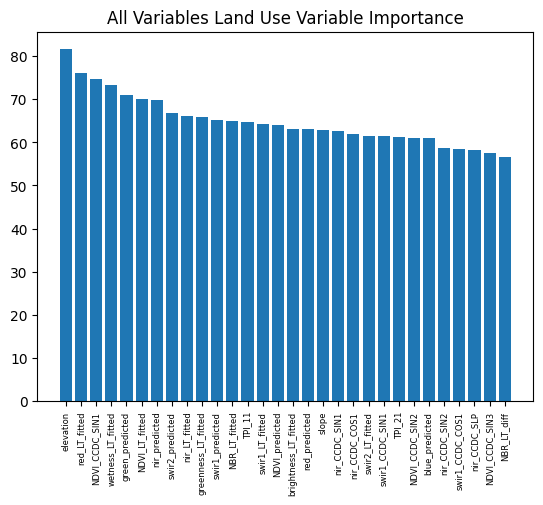

Adding layer: Land Use All Variables
Top 30 Variables Land Use OOB Accuracy: 0.9937589328251548


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11823,0,0,0,100
Non-Forest Wetland,0,0,1,997,1,0,99
Other,0,0,0,0,815,0,100
Rangeland or Pasture,0,0,1,0,0,2906,99
Consumers Accuracy,100,100,99,100,99,100,99


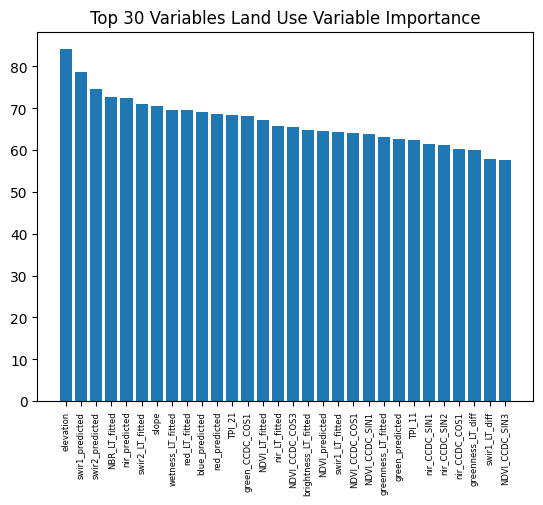

Adding layer: Land Use Top 30
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [08/Aug/2023 00:17:49] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [96]:
# Not let's train and apply a RandomForest model for Land Use
Map.clearMap()
# Set up RF model using all variables
rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

rf_lu = rf_lu.train(training_data, reference_field_dict['Land_Use']['field']+'_Code', predictor_field_names)#['NBR_LT_fitted'])

importance = getModelInfo(rf_lu, lcms_viz_dict['Land_Use_class_names'][:-1],'All Variables Land Use')
lu_predicted = predictor_stack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)

Map.addLayer(lu_predicted,{'autoViz':True},'Land Use All Variables')

# importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
lu_predictor_field_names =  list(importance.keys())
rf_lu = rf_lu.train(training_data, reference_field_dict['Land_Use']['field']+'_Code',lu_predictor_field_names)#['NBR_LT_fitted'])
# importance = rf_lc.explain().get('importance').getInfo()
getModelInfo(rf_lu, lcms_viz_dict['Land_Use_class_names'][:-1],f'Top {top_n_variables} Variables Land Use')
# var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


lu_predicted = predictor_stack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)
# # print(lc_predicted.bandNames().getInfo())
Map.addLayer(lu_predicted,{'autoViz':True},f'Land Use Top {top_n_variables}')
Map.turnOnInspector()
Map.view()

# Map.clearMap()
# nTrees = 2
# seed = 999
# rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# rf_lu = rf_lc.train(training_data, reference_field_dict['Land_Use']['field']+'_Code', ['NBR_LT_fitted'])
# # print(rf_lc.schema().getInfo())

# lu_predicted = extractionStack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)
# # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lu_predicted,{'autoViz':True},'Land Use')
# Map.turnOnInspector()
# Map.view()

In [103]:
# Change is handled differently
# Since change is a rare class, models are not confident on all but the most severe change
# Therefore we model each change class separately
change_fields = reference_field_dict['Change']['fields']

for change_field in change_fields:
    n = training_data.filter(ee.Filter.eq(change_field,1))
    print(change_field,n.size().getInfo())

training_data.first().getInfo()

Slow Loss 0
Fast Loss 0
Gain 0


{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-64.78490580239071, 18.32868451098288]},
 'id': '0_00000000000000000001',
 'properties': {'BARREN': 0,
  'BARREN-GRA': 0,
  'BARREN-IMP': 0,
  'BARREN-SHR': 0,
  'BARREN-TRE': 1,
  'BARREN-TS': 0,
  'CHANGE_DUR': 2,
  'COMMENTS': '',
  'CP': 'Stable',
  'CP_NOTES': '',
  'DOM_LC': 'Barren',
  'DOM_LU': 'Forest',
  'DOM_LU_Code': 3,
  'DOM_LU_EL': '',
  'DOM_SEC_LC': 'BARREN-TRE',
  'DOM_SEC_LC_Code': 5,
  'GRASS': 0,
  'GRASS-SHRU': 0,
  'GRASS-TREE': 0,
  'GRASS-TS': 0,
  'IMPERVIOUS': 0,
  'INTERP': 48,
  'JULIANDAY': 135,
  'LAST_MODIF': '6/22/2021 12:06',
  'NBR_LT_diff': -0.006684624368081889,
  'NBR_LT_dur': 24,
  'NBR_LT_fitted': 0.5767692985806379,
  'NBR_LT_mag': -0.010026936552122834,
  'NBR_LT_slope': -0.00041778902300511805,
  'NDVI_CCDC_COS1': 0.057901283742523624,
  'NDVI_CCDC_COS2': 0.007792101065656297,
  'NDVI_CCDC_COS3': 0.017079822551271356,
  'NDVI_CCDC_INTP': -10.289777575057801,
  'NDVI_CCDC_SIN1

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,type,id,geometry.type,geometry.coordinates,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
0,Feature,0_00000000000000000001,Point,"[-64.78490580239071, 18.32868451098288]",0,0,0,0,1,0,...,25,0.064479,0.001574,0.000063,-0.017791,38,-0.048918,-0.042253,-0.001112,2001.068481
1,Feature,0_00000000000000000002,Point,"[-66.70373279040638, 18.011111793057527]",0,0,0,0,1,0,...,16,0.193569,0.086700,0.005419,0.135325,1,-0.144873,0.135325,0.135325,2000.871216
2,Feature,0_00000000000000000004,Point,"[-66.9880049416646, 17.99814918629516]",0,0,0,0,0,0,...,27,0.101287,-0.031124,-0.001153,0.017487,3,-0.122488,0.052460,0.017487,2001.394531
3,Feature,0_00000000000000000005,Point,"[-66.39790980375685, 18.238316369033754]",0,0,0,0,0,0,...,23,0.118775,0.075588,0.003286,-0.092580,17,-0.139831,-0.098366,-0.005786,2001.394531
4,Feature,0_00000000000000000007,Point,"[-66.1090893694241, 18.33875316116157]",0,0,0,0,0,0,...,38,0.108382,0.078610,0.002069,-0.030306,38,-0.104347,-0.071976,-0.001894,2001.024658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20986,Feature,20_000000000000000003c6,Point,"[-66.48076436043094, 18.37840794682986]",0,0,0,0,0,0,...,19,0.090972,-0.022253,-0.001171,0.014588,38,-0.081403,0.015398,0.000405,2021.169922
20987,Feature,20_000000000000000003d5,Point,"[-66.41963900319028, 17.9634618392004]",0,0,0,0,0,0,...,38,0.198107,0.120550,0.003172,0.130122,4,-0.094719,0.130122,0.032531,2021.169922
20988,Feature,20_000000000000000003d6,Point,"[-66.97177827293112, 17.990492909786393]",0,0,0,0,0,0,...,4,0.073216,-0.037104,-0.009276,-0.029875,38,-0.065902,-0.031535,-0.000830,2021.216431
20989,Feature,20_000000000000000003d9,Point,"[-67.01755986344685, 18.0568309561585]",0,0,0,0,0,0,...,38,0.065037,-0.015885,-0.000418,0.019723,38,-0.063670,0.020818,0.000548,2021.087646


0.9730228680323963


red_LT_fitted           0.041240
swir2_CCDC_fitted       0.038562
green_CCDC_fitted       0.031643
NDVI_LT_fitted          0.031348
NBR_LT_fitted           0.030899
red_CCDC_fitted         0.029688
wetness_LT_fitted       0.029440
NDVI_CCDC_fitted        0.027784
swir2_LT_fitted         0.027733
swir1_CCDC_fitted       0.022274
blue_CCDC_fitted        0.021825
swir1_LT_fitted         0.019051
brightness_LT_fitted    0.016810
greenness_LT_fitted     0.015741
NDVI_CCDC_COS1          0.014337
NDVI_CCDC_SIN1          0.012800
nir_LT_fitted           0.012544
swir1_CCDC_SIN1         0.011708
nir_CCDC_COS1           0.011175
nir_CCDC_fitted         0.011028
nir_CCDC_SIN1           0.010027
TPI_41                  0.009905
nir_CCDC_SIN2           0.009882
red_LT_mag              0.009827
red_CCDC_SIN1           0.009801
red_CCDC_COS1           0.009476
TPI_21                  0.008735
TPI_11                  0.008489
greenness_LT_mag        0.008419
NDVI_LT_mag             0.008382
dtype: flo

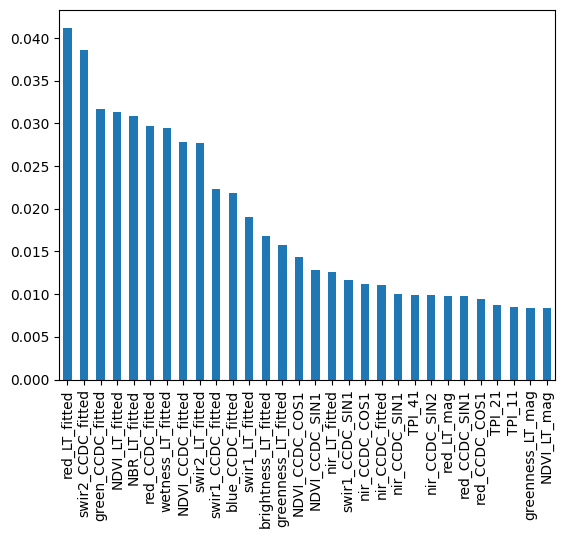

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

import os

# Specify a local location to store LCMS training data \
local_training_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_training_data_folder,'timeSync_training_table.csv')

seed = 999
nTrees = 50
if not os.path.exists(local_training_data_folder):os.makedirs(local_training_data_folder)

g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)
training_df = pd.read_csv(local_training_csv)
X = training_df[predictor_field_names]
y = training_df[reference_field_dict['Land_Cover']['field']+'_Code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
display(training_df)
rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
# print(training_df[reference_field_dict['Land_Cover']['field']+'_Code'])
rf.fit(X_train,y_train)
# print(clf)
oob_acc = rf.oob_score_
print(oob_acc)
# print(clf.classes_)
# print(clf.feature_importances_)
feature_importances = pd.Series(rf.feature_importances_, index=predictor_field_names).sort_values(ascending=False).iloc[:30]
display(feature_importances)
# Plot a simple bar chart
feature_importances.plot.bar(rot=90);
# importance_dict = dict(zip(predictor_field_names,clf.feature_importances_))
# var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = top_n_variables,descending = True)
# display(training_df[['wetness_LT_fitted','NBR_LT_fitted']])

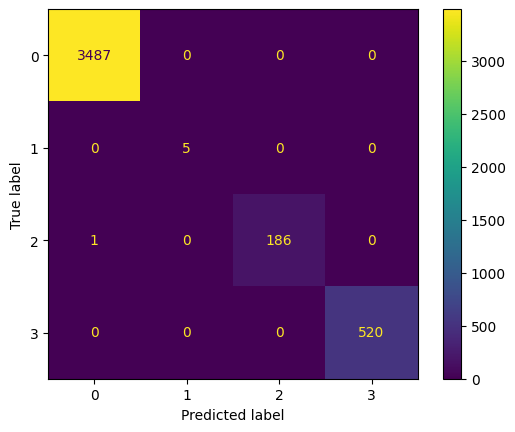

In [64]:
# Generate predictions with the best model
y_pred = rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [76]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10,scoring = 'balanced_accuracy')
scores
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 balanced accuracy with a standard deviation of 0.04


NBR_LT_fitted           0.050181
red_LT_fitted           0.047087
green_predicted         0.036395
wetness_LT_fitted       0.036058
red_predicted           0.028687
NDVI_predicted          0.028161
blue_predicted          0.028139
swir1_predicted         0.027217
swir2_LT_fitted         0.022334
swir2_predicted         0.020669
NDVI_LT_fitted          0.020262
elevation               0.018187
swir1_LT_fitted         0.016881
greenness_LT_fitted     0.016566
slope                   0.013727
nir_LT_fitted           0.013403
brightness_LT_fitted    0.012256
nir_CCDC_COS1           0.012066
nir_predicted           0.012056
NDVI_CCDC_COS1          0.011387
red_CCDC_SIN1           0.010539
NDVI_CCDC_SIN1          0.009807
NDVI_LT_mag             0.009654
swir1_CCDC_SIN1         0.009608
nir_CCDC_SIN1           0.009445
NDVI_CCDC_SIN2          0.009299
swir2_CCDC_SIN1         0.009106
hillshade               0.008877
green_CCDC_COS1         0.008858
nir_CCDC_SIN2           0.008747
dtype: flo

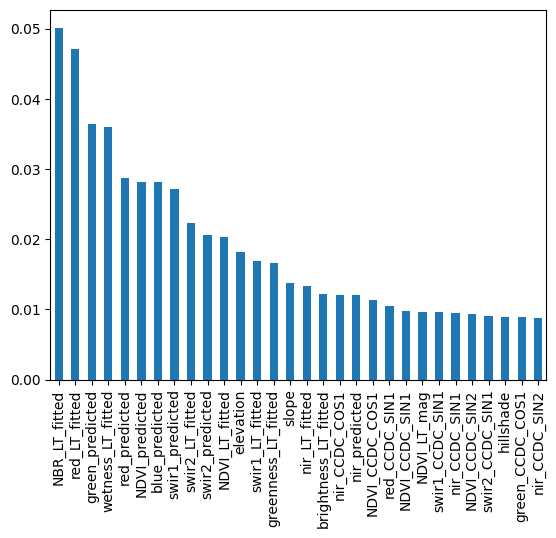

In [79]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_transformed = scaler.transform(X_train)
clf = rf.fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

feature_importances = pd.Series(clf.feature_importances_, index=predictor_field_names).sort_values(ascending=False).iloc[:30]
display(feature_importances)
# Plot a simple bar chart
feature_importances.plot.bar(rot=90);

In [83]:
Map.clearMap()
# Now lets export predicted assets
# First, we'll set up the study area and a tile to export across

studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary_buff2mile')

# Set the size (in meters) of the tiles
tileSize = 60000

# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)

# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))
Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))

Map.centerObject(studyArea)
Map.view()

Adding layer: Tile Grid 60000m
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [07/Aug/2023 23:50:53] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [ ]:
# Set up params
nTrees = 